In [1]:
import numpy as np
import yaml, torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display
from tqdm import trange

from pfmatch import DataGen
from pfmatch.photonlib.photon_library import PhotonLibrary
from pfmatch.algorithm.match_model import PoissonMatchLoss

## How-to: 2D loss scan

In this notebook we cover a simple example of scanning a loss surface.
1. Generate a single track-flash pair
2. Visualize
3. Scan along the drift direction

### Setup

* Load configurations
* Create two API instances: data generator (which makes a flash-track pair) and loss calculator

In [2]:
# Configurations
det_yaml='../data/config/detector_specs.yml'
det_cfg = yaml.load(open(det_yaml), Loader=yaml.Loader)['DetectorSpecs']
gen_yaml='../data/config/flashmatch.yml'
gen_cfg = yaml.load(open(gen_yaml), Loader=yaml.Loader)

# Data generator construction
plib = PhotonLibrary('plib.h5')
generator = DataGen(det_cfg, gen_cfg, plib)

# Loss calculator
loss_fn = PoissonMatchLoss()

## Data generation

Create a track-shower pair and visualize them.

In [3]:
#Active volume bounds for all axes
def create_box_outline(color='black', width=2):
    xmin, ymin, zmin = det_cfg['ActiveVolumeMin']
    xmax, ymax, zmax = det_cfg['ActiveVolumeMax']
    # Define the box's vertices    
    vertices = [
        [xmin, ymin, zmin], [xmax, ymin, zmin],
        [xmin, ymax, zmin], [xmax, ymax, zmin],
        [xmin, ymin, zmax], [xmax, ymin, zmax],
        [xmin, ymax, zmax], [xmax, ymax, zmax]
    ]

    # Define the edges by connecting the vertices
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],
        [4, 5], [5, 7], [7, 6], [6, 4],
        [0, 4], [1, 5], [2, 6], [3, 7]
    ]

    # Create a Scatter3d trace for the box outline
    traces = [go.Scatter3d(x=[vertices[i][0], vertices[j][0]],
                        y=[vertices[i][1], vertices[j][1]],
                        z=[vertices[i][2], vertices[j][2]],
                        mode='lines',
                        line=dict(color=color, width=width),
                        showlegend=False)
                for (i,j) in edges]
    return traces

Flash (PMT v.s. PE)


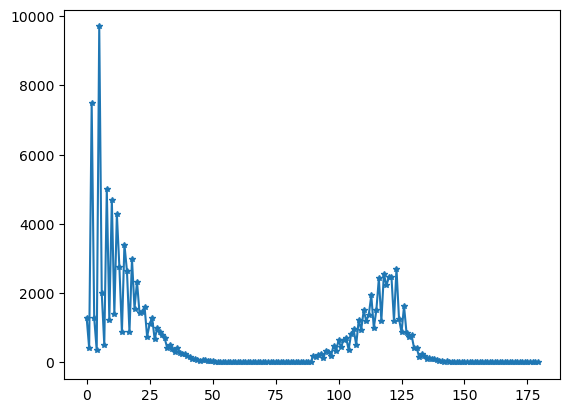

Trajectory 3D points


In [19]:
#Generating one flash-match pair of qcluster and flash
pair = generator.make_flashmatch_inputs(1)

# Plot a flash 
print('Flash (PMT v.s. PE)')
truth_flash = pair.flash_v[0]
plt.plot(np.arange(truth_flash.pe_v.shape[0]),truth_flash.pe_v.cpu().numpy(),marker='*',markersize=4)
plt.show()

# Visualize a Track
print('Trajectory 3D points')
qc = pair.qcluster_v[0]
pts=qc.qpt_v.cpu().numpy()
trace=go.Scatter3d(x=pts[:,0],y=pts[:,1],z=pts[:,2], showlegend=False)
fig=go.Figure()
fig.update_layout(
    scene=dict(
        aspectmode="data",
        camera=dict(up=dict(x=0, y=1, z=0),
                    center=dict(x=0, y=0, z=-1),
                    eye=dict(x=0.0, y=0, z=2.5)
                    )
    )
)
fig.add_trace(trace)
fig.add_traces(create_box_outline('grey'))
fig.show()

## Loss calculation


Initial loss from a random xshift away from the true x value

In [20]:
#Flash hypothesis from shifted qcluster
hypothesis = generator.make_flash(qc)

true_xshift = qc.time_true*det_cfg["DriftVelocity"]
#Loss
loss0 = loss_fn(hypothesis.pe_v, truth_flash.pe_v)

print(f"Loss: {loss0.item():.2f}")
print(f'True x-shift: {true_xshift:.2f} cm')

Loss: 125.91
True x-shift: 46.80 cm


## Loss scan

Now let the trajectory shift along the x-axis and compute the loss value.

In [21]:
#True boundary values for all axes
qc_xmin = qc.qpt_v[:,0].min().item()
qc_xmax = qc.qpt_v[:,0].max().item()

qc_ymin = qc.qpt_v[:,1].min().item()
qc_ymax = qc.qpt_v[:,1].max().item()

qc_zmin = qc.qpt_v[:,2].min().item()
qc_zmax = qc.qpt_v[:,2].max().item()

#Active volume bounds for all axes
active_xmin = det_cfg['ActiveVolumeMin'][0]
active_xmax = det_cfg['ActiveVolumeMax'][0]

active_ymin = det_cfg['ActiveVolumeMin'][1]
active_ymax = det_cfg['ActiveVolumeMax'][1]

active_zmin = det_cfg['ActiveVolumeMin'][2]
active_zmax = det_cfg['ActiveVolumeMax'][2]

shift_init  = qc_xmin - active_xmin
shift_total = (active_xmax - active_xmin) - (qc_xmax - qc_xmin)

shift_y_init  = qc_ymin - active_ymin
shift_y_total = (active_ymax - active_ymin) - (qc_ymax - qc_ymin)

shift_z_init  = qc_zmin - active_zmin
shift_z_total = (active_zmax - active_zmin) - (qc_zmax - qc_zmin)

NSTEPS_X = 100 # number of samples along x axis
dx = shift_total/NSTEPS_X

NSTEPS_Y = 100 # number of samples along x axis
dy = shift_y_total/NSTEPS_Y

NSTEPS_Z = 100 # number of samples along x axis
dz = shift_z_total/NSTEPS_Z

qpt_v_copy = qc.qpt_v.clone()

In [22]:
from tqdm import trange

print("X-Z plane")

loss_v_xz=[] # a list to store the computed loss values in the loop below

NSTEPS_X = 100 # number of samples along x axis
dx = shift_total/NSTEPS_X # the step size to move the trajectory along x

NSTEPS_Z = 100 # number of samples along z axis
dz = shift_z_total/NSTEPS_Z # the step size to move the trajectory along z

# Loop over NSTEPS, apply dx & dz, compute the loss 
qc.qpt_v = qpt_v_copy.clone()
qc.qpt_v[:,0] -= shift_init
qc.qpt_v[:,2] -= shift_z_init
for i in trange(NSTEPS_X):
    # shift dx
    qc.qpt_v[:,0] += dx
    for j in range(NSTEPS_Z):
        # shift dz
        qc.qpt_v[:,2] += dz

        #Flash hypothesis from shifted qcluster
        hypothesis = generator.make_flash(qc)
        #Loss
        loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
        loss_v_xz.append(loss.cpu().item())
    # reset z axis
    qc.qpt_v[:, 2] -= shift_z_total

X-Z plane


100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


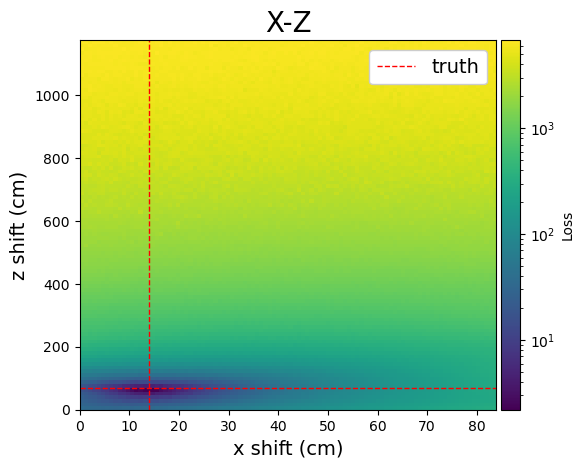

In [23]:
from matplotlib.colors import LogNorm

reshaped_loss = np.array(loss_v_xz).reshape(NSTEPS_X,NSTEPS_Z)
plt.imshow(reshaped_loss.T, origin='lower', extent=[0, dx*NSTEPS_X, 0, dz*NSTEPS_Z], aspect='auto', norm=LogNorm())
plt.axvline(shift_init-true_xshift, color='r', ls='--', lw=1, label='truth')
plt.axhline(shift_z_init, color='r', ls='--', lw=1)
plt.colorbar(pad=0.01, label='Loss')
plt.xlabel('x shift (cm)', fontsize=14)
plt.ylabel('z shift (cm)', fontsize=14)
plt.legend(framealpha=1, fontsize=14)
plt.title('X-Z', fontsize=20)
plt.show()

In [24]:
from tqdm import trange

print("X-Y plane")
# Step4, scan the loss value
loss_v_xy=[] # a list to store the computed loss values in the loop below

NSTEPS_X = 100 # number of samples along x axis
dx = shift_total/NSTEPS_X # the step size to move the trajectory along x

NSTEPS_Y = 100 # number of samples along y axis
dy = shift_y_total/NSTEPS_Y # the step size to move the trajectory along y

# Apply initial shift
qc.qpt_v = qpt_v_copy.clone()
qc.qpt_v[:,0] -= shift_init
qc.qpt_v[:,1] -= shift_y_init
# Loop over NSTEPS, apply dx, compute the loss

for i in trange(NSTEPS_X):
    # shift dx
    qc.qpt_v[:,0] += dx
    
    for j in range(NSTEPS_Y):
        # shift dy
        qc.qpt_v[:,1] += dy
        #Flash hypothesis from shifted qcluster
        hypothesis = generator.make_flash(qc)
        #Loss
        loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
        loss_v_xy.append(loss.cpu().item())
    qc.qpt_v[:, 1] -= shift_y_total

X-Y plane


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


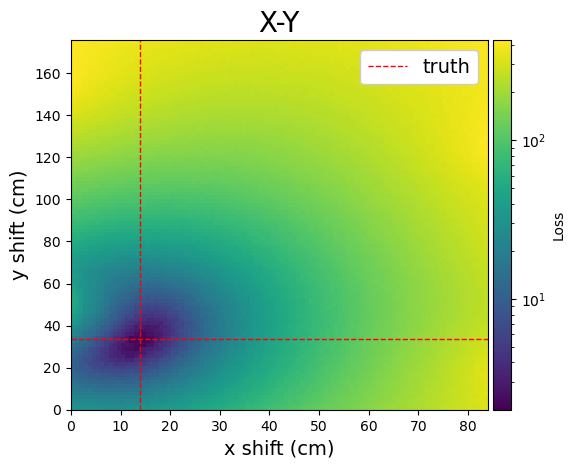

In [25]:
reshaped_loss = np.array(loss_v_xy).reshape(NSTEPS_X,NSTEPS_Y)
plt.imshow(reshaped_loss.T, origin='lower', extent=[0, dx*NSTEPS_X, 0, dy*NSTEPS_Y], aspect='auto', norm=LogNorm())
plt.axvline(shift_init-true_xshift, color='r', ls='--', lw=1, label='truth')
plt.axhline(shift_y_init, color='r', ls='--', lw=1)
plt.colorbar(pad=0.01, label='Loss')
plt.xlabel('x shift (cm)', fontsize=14)
plt.ylabel('y shift (cm)', fontsize=14)
plt.legend(framealpha=1, fontsize=14)
plt.title('X-Y', fontsize=20)
plt.show()

In [26]:
from tqdm import trange

print("Y-Z plane")

# a list to store the computed loss values in the loop below
loss_v_yz = []

NSTEPS_Y = 100 # number of samples along y axis
dy = shift_y_total/NSTEPS_Y # the step size to move the trajectory along y

NSTEPS_Z = 100 # number of samples along z axis
dz = shift_z_total/NSTEPS_Z # the step size to move the trajectory along z

# from perfect clone, init shift
qc.qpt_v = qpt_v_copy.clone()
# shifted such that the initial x position is the same as the truth
qc.qpt_v[:,0] -= (shift_init-true_xshift)
qc.qpt_v[:,1] -= shift_y_init
qc.qpt_v[:,2] -= shift_z_init

# Loop over NSTEPS, apply dy & dz, compute the loss
for i in trange(NSTEPS_Y):
    # shift y
    qc.qpt_v[:,1] += dy

    for j in range(NSTEPS_Z):
        # shift z
        qc.qpt_v[:,2] += dz
        # Flash hypothesis from shifted qcluster
        hypothesis = generator.make_flash(qc)
        # Loss
        loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
        loss_v_yz.append(loss.cpu().item())
    # reset z axis
    qc.qpt_v[:, 2] -= shift_z_total

Y-Z plane


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


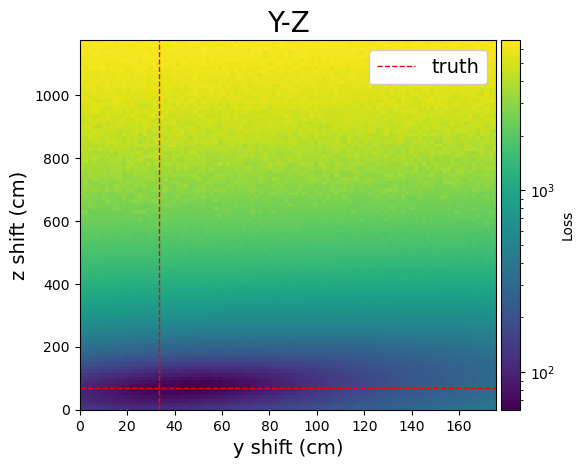

In [27]:
from matplotlib.colors import LogNorm

reshaped_loss = np.array(loss_v_yz).reshape(NSTEPS_X,NSTEPS_Y)
plt.imshow(reshaped_loss.T, origin='lower', extent=[0, dy*NSTEPS_Y, 0, dz*NSTEPS_Z], aspect='auto', norm=LogNorm())
plt.colorbar(pad=0.01, label='Loss')
plt.axvline(shift_y_init, color='red', linestyle='--', lw=1, label='truth')
plt.axhline(shift_z_init, color='red', linestyle='--', lw=1)

# plt.contour(reshaped_loss, origin='lower', extent=[0, dy*NSTEPS_Y, 0, dz*NSTEPS_Z], cmap='pink_r', levels=10, alpha=0.5)
plt.xlabel('y shift (cm)', fontsize=14)
plt.ylabel('z shift (cm)', fontsize=14)
plt.title('Y-Z', fontsize=20)
plt.legend(framealpha=1, fontsize=14)
plt.show()

In [13]:
# Step1, record the true boundary x values that include the trajectory
print('The trajectory spans X:',qc_xmin,'=>',qc_xmax)

# Step2, get the active volume bounds along the x-axis
print('The active volume spans X:',active_xmin,'=>',active_xmax)

# Step3, figure out the shift.
# 1. calculate the lowest x position to shift (where the tracjectory touches the active volume minimum)
# 2. calculate the highest x position to shift (where the trajectory touches the active volume maximum)
print('Will shift the x-position of the trajectory by:', shift_init)
print('Then move the trajectory up to:', shift_total)

# Step4, scan the loss value
NSTEPS_X = 100 # number of samples along x axis
dx = shift_total/NSTEPS_X # the step size to move the trajectory along x
loss_v=[] # a list to store the computed loss values in the loop below

# Loop over NSTEPS, apply dx, compute the loss
# Apply the initial shift
qc.qpt_v = qpt_v_copy.clone()
qc.qpt_v[:,0] -= shift_init
for i in range(NSTEPS_X):
    # shift
    qc.qpt_v[:,0] += dx
    #Flash hypothesis from shifted qcluster
    hypothesis = generator.make_flash(qc)
    #Loss
    loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
    loss_v.append(loss.cpu().item())

The trajectory spans X: -105.90012208815074 => 23.64117582444692
The active volume spans X: -358.49 => -61.94
Will shift the x-position of the trajectory by: 252.58987791184927
Then move the trajectory up to: 167.00870208740236


Letting the trajectory shift along the y-axis next.

In [14]:
# Step1, record the true boundary y values that include the trajectory
print('The trajectory spans Y:',qc_ymin,'=>',qc_ymax)

# Step2, get the active volume bounds along the x-axis
print('The active volume spans Y:',active_ymin,'=>',active_ymax)

# Step3, figure out the shift.
# 1. calculate the lowest y position to shift (where the tracjectory touches the active volume minimum)
# 2. calculate the highest y position to shift (where the trajectory touches the active volume maximum)
print('Will shift the y-position of the trajectory by:', shift_y_init)
print('Then move the trajectory up to:', shift_y_total)

# Step 4, scan the loss value
NSTEPS_Y = 100 # number of samples along x axis
dy = shift_y_total/NSTEPS_Y # the step size to move the trajectory along y
loss_y_v=[] # a list to store the computed loss values in the loop below

# Apply the initial shift
qc.qpt_v = qpt_v_copy.clone()
qc.qpt_v[:, 1] -= shift_y_init
# Loop over NSTEPS, apply dy, compute the loss
for i in range(NSTEPS_Y):
    # shift
    qc.qpt_v[:,1] += dy
    #Flash hypothesis from shifted qcluster
    hypothesis = generator.make_flash(qc)
    #Loss
    loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
    loss_y_v.append(loss.cpu().item())

The trajectory spans Y: -83.06555938720703 => 119.26590728759766
The active volume spans Y: -181.86 => 134.96
Will shift the y-position of the trajectory by: 98.79444061279298
Then move the trajectory up to: 114.48853332519536


Letting the trajectory shift along the z-axis

In [15]:
# Step1, record the true boundary z values that include the trajectory
print('The trajectory spans Z:',qc_zmin,'=>',qc_zmax)

# Step2, get the active volume bounds along the z-axis
print('The active volume spans Z:',active_zmin,'=>',active_zmax)

# Step3, figure out the shift.
# 1. calculate the lowest z position to shift (where the tracjectory touches the active volume minimum)
# 2. calculate the highest z position to shift (where the trajectory touches the active volume maximum)
print('Will shift the z-position of the trajectory by:', shift_z_init)
print('Then move the trajectory up to:', shift_z_total)

# Step4, scan the loss value
NSTEPS_Z = 100 # number of samples along x axis
dz = shift_z_total/NSTEPS_Z # the step size to move the trajectory along z
loss_z_v=[] # a list to store the computed loss values in the loop below

# Loop over NSTEPS, apply dz, compute the loss
qc.qpt_v = qpt_v_copy.clone()
qc.qpt_v[:, 2] -= shift_z_init
for i in range(NSTEPS_Z):
    # shift
    qc.qpt_v[:,2] += dz
    #Flash hypothesis from shifted qcluster
    hypothesis = generator.make_flash(qc)
    #Loss
    loss = loss_fn(hypothesis.pe_v, truth_flash.pe_v)
    loss_z_v.append(loss.cpu().item())

The trajectory spans Z: -636.91943359375 => -137.23814392089844
The active volume spans Z: -894.951 => 894.951
Will shift the z-position of the trajectory by: 258.03156640625
Then move the trajectory up to: 1290.2207103271485


## Plot the loss

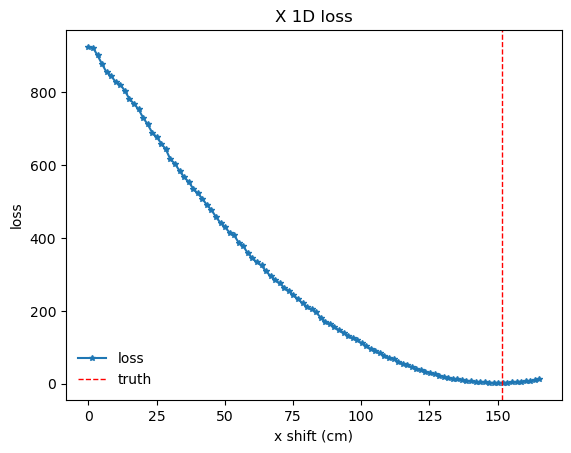

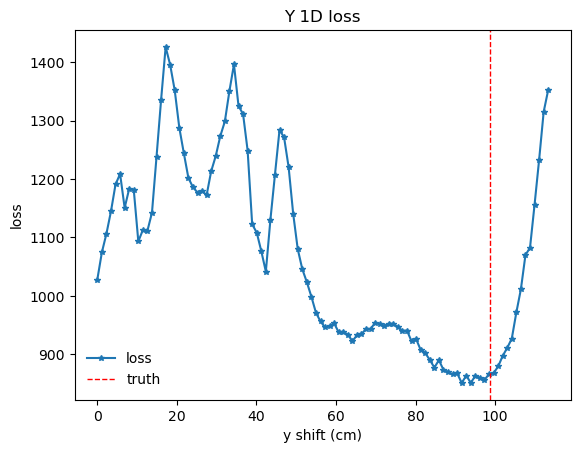

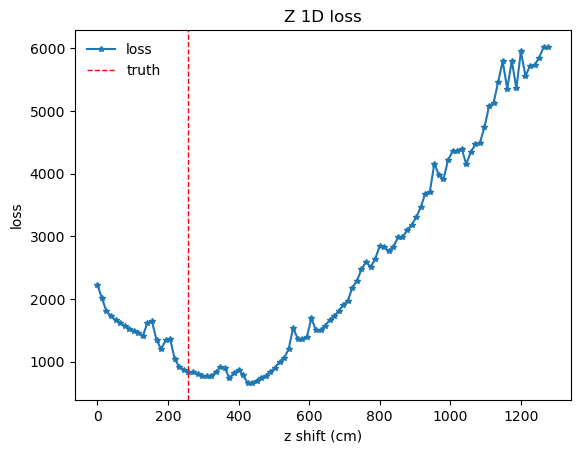

In [16]:
plt.plot(dx*np.arange(len(loss_v)),loss_v,marker='*',markersize=4, label='loss')
plt.axvline(shift_init-true_xshift, color='r', ls='--', lw=1, label='truth')
plt.title("X 1D loss")
plt.xlabel('x shift (cm)')
plt.ylabel("loss")
plt.legend(frameon=False)
plt.show()

plt.plot(dy*np.arange(len(loss_y_v)),loss_y_v,marker='*',markersize=4, label='loss')
plt.axvline(shift_y_init, color='r', ls='--', lw=1, label='truth')
plt.title("Y 1D loss")
plt.xlabel('y shift (cm)')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()

plt.plot(dz*np.arange(len(loss_z_v)),loss_z_v,marker='*',markersize=4, label='loss')
plt.axvline(shift_z_init, color='r', ls='--', lw=1, label='truth')
plt.title("Z 1D loss")
plt.xlabel('z shift (cm)')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()